# Intelligent systems - Assignment 2: Text Classification

## Data preparation and exploration

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JERNEJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\JERNEJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JERNEJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JERNEJ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load data and extract basic information

In [2]:
file_path = 'dataset.jsonl'
df = pd.read_json(file_path, lines=True)

In [3]:
missing_values = df.isnull().sum()
print("Missing values per column:\n")
print(missing_values)

Missing values per column:

text     0
label    0
dtype: int64


Class distribution:

label
1    1703
0    1443
3     671
4     584
2     401
5     198
Name: count, dtype: int64


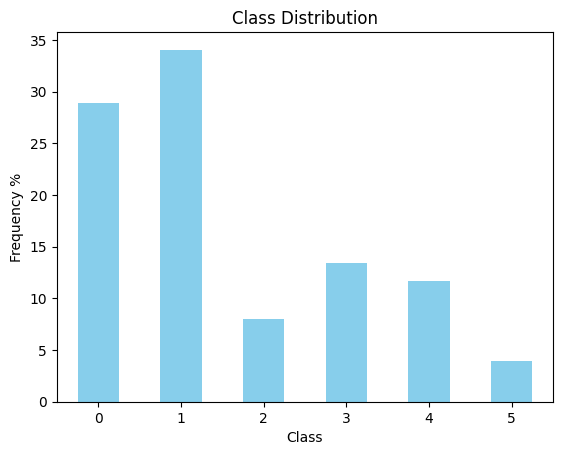

In [4]:
class_distribution = df['label'].value_counts()
print("Class distribution:\n")
print(class_distribution)
class_distribution = class_distribution / np.sum(class_distribution) * 100
class_distribution.sort_index().plot(kind='bar', color='skyblue')
plt.xticks(rotation=0)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency %')
plt.show()

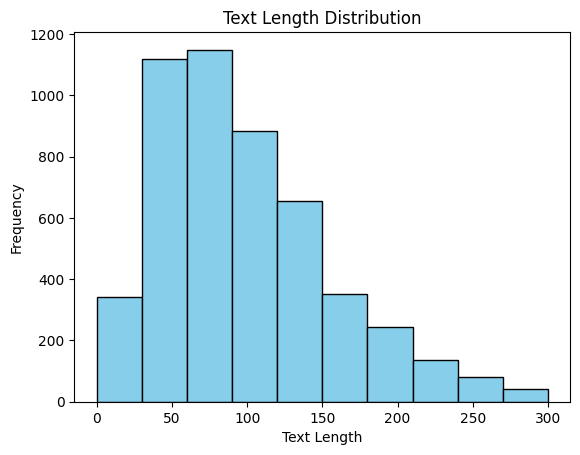

In [5]:
df['text_length'] = df['text'].apply(len)
bins = np.linspace(0, 300, 11)

plt.hist(df['text_length'], bins=bins, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

### Split data

In [6]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=17)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=17)

print("Data split sizes:\n")
print(f"Train set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Data split sizes:

Train set: 3500
Validation set: 750
Test set: 750


### Transform data for machine learning

In [7]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text):
    words = word_tokenize(text.lower())

    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words if word.isalpha()]

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    stemmed_words = [stemmer.stem(word) for word in words]

    preprocessed_text = ' '.join(lemmatized_words)
    
    return preprocessed_text

In [8]:
train_df['text'] = train_df['text'].apply(preprocess_text)
val_df['text'] = val_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [9]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

## Basic machine learning

In [10]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation for {model_name}:\n")
    print(classification_report(y_true, y_pred))
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Classification accuracy: {accuracy:.3f}")
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1 score: {f1:.3f}")
    
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='.1%', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    return accuracy, f1, cm

### Decision tree

Evaluation for Decision Tree:

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       216
           1       0.91      0.86      0.88       256
           2       0.75      0.85      0.80        60
           3       0.87      0.84      0.85       100
           4       0.83      0.86      0.84        88
           5       0.81      0.83      0.82        30

    accuracy                           0.87       750
   macro avg       0.84      0.86      0.85       750
weighted avg       0.88      0.87      0.87       750

Classification accuracy: 0.873
F1 score: 0.852


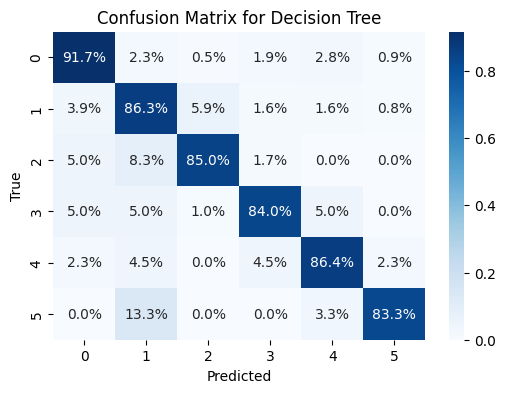

In [35]:
dt = DecisionTreeClassifier(random_state=17)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

dt_accuracy, dt_f1, dt_cm = evaluate_model(y_test, y_pred, "Decision Tree")

### Naive Bayes

Evaluation for Naive Bayes:

              precision    recall  f1-score   support

           0       0.69      0.93      0.79       216
           1       0.66      0.91      0.76       256
           2       0.62      0.08      0.15        60
           3       0.89      0.50      0.64       100
           4       0.89      0.36      0.52        88
           5       1.00      0.07      0.12        30

    accuracy                           0.70       750
   macro avg       0.79      0.48      0.50       750
weighted avg       0.74      0.70      0.65       750

Classification accuracy: 0.699
F1 score: 0.498


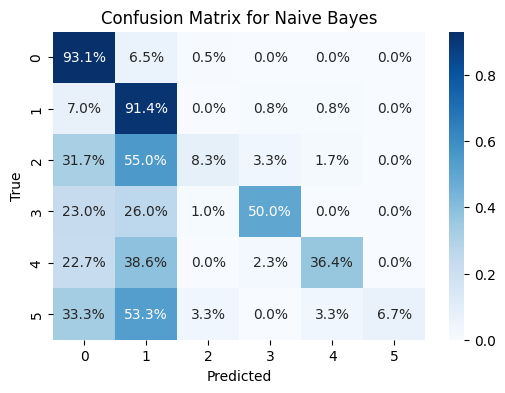

In [12]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)

y_pred = naive_bayes.predict(X_test)

nb_accuracy, nb_f1, nb_cm = evaluate_model(y_test, y_pred, "Naive Bayes")

### Support vector machine

Evaluation for SVM:

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       216
           1       0.88      0.90      0.89       256
           2       0.75      0.72      0.74        60
           3       0.85      0.83      0.84       100
           4       0.86      0.83      0.84        88
           5       0.72      0.87      0.79        30

    accuracy                           0.86       750
   macro avg       0.83      0.84      0.83       750
weighted avg       0.86      0.86      0.86       750

Classification accuracy: 0.861
F1 score: 0.831


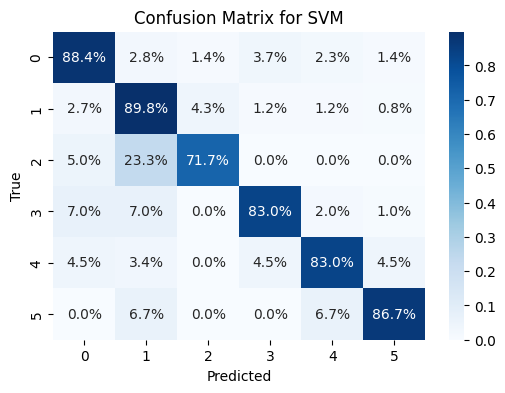

In [24]:
svm = SVC(kernel='linear', class_weight='balanced', random_state=17)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

svm_accuracy, svm_f1, svm_cm = evaluate_model(y_test, y_pred, "SVM")

Evaluation for Random Forest:

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       216
           1       0.86      0.91      0.88       256
           2       0.80      0.68      0.74        60
           3       0.87      0.86      0.86       100
           4       0.88      0.88      0.88        88
           5       0.78      0.83      0.81        30

    accuracy                           0.87       750
   macro avg       0.85      0.84      0.85       750
weighted avg       0.87      0.87      0.87       750

Classification accuracy: 0.873
F1 score: 0.846


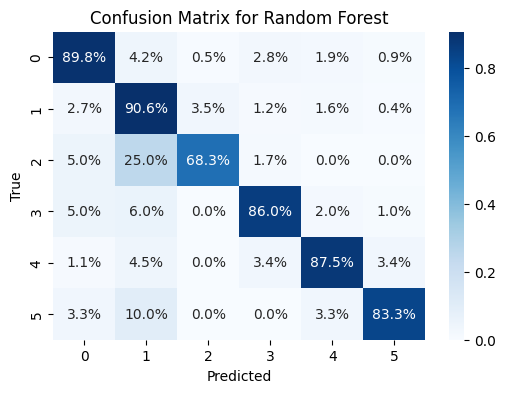

In [14]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=17, bootstrap=False)
rf_clf.fit(X_train, y_train)

rf_preds = rf_clf.predict(X_test)

rf_accuracy, rf_f1, rf_cm = evaluate_model(y_test, rf_preds, "Random Forest")

### Hyperparameter tuning

In [15]:
dt_param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 20],
    'bootstrap': [True, False]
}

dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)

svm_grid_search = GridSearchCV(estimator=svm, param_grid=svm_param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)

rf_grid_search = GridSearchCV(estimator=rf_clf, param_grid=rf_param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False, random_state=17),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [None, 5, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

Evaluation for Decision Tree (Optimized):

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       216
           1       0.92      0.86      0.89       256
           2       0.75      0.87      0.81        60
           3       0.88      0.83      0.86       100
           4       0.87      0.83      0.85        88
           5       0.72      0.97      0.83        30

    accuracy                           0.88       750
   macro avg       0.84      0.88      0.86       750
weighted avg       0.88      0.88      0.88       750

Classification accuracy: 0.880
F1 score: 0.858


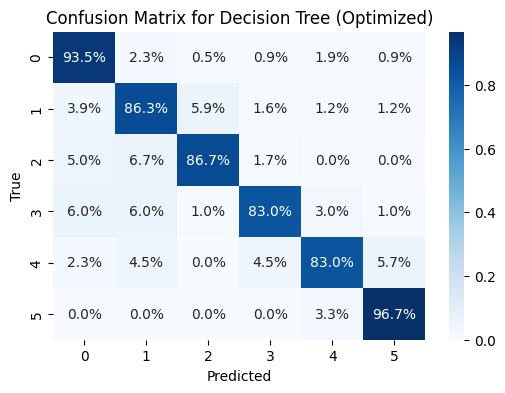

Evaluation for SVM (Optimized):

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       216
           1       0.88      0.90      0.89       256
           2       0.75      0.72      0.74        60
           3       0.85      0.83      0.84       100
           4       0.86      0.83      0.84        88
           5       0.72      0.87      0.79        30

    accuracy                           0.86       750
   macro avg       0.83      0.84      0.83       750
weighted avg       0.86      0.86      0.86       750

Classification accuracy: 0.861
F1 score: 0.831


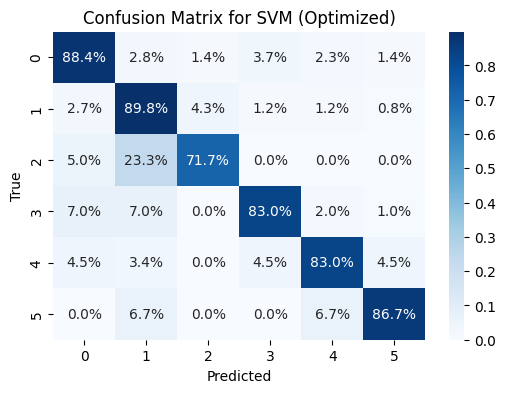

Evaluation for Random Forest (Optimized):

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       216
           1       0.86      0.91      0.88       256
           2       0.80      0.68      0.74        60
           3       0.87      0.86      0.86       100
           4       0.88      0.88      0.88        88
           5       0.78      0.83      0.81        30

    accuracy                           0.87       750
   macro avg       0.85      0.84      0.85       750
weighted avg       0.87      0.87      0.87       750

Classification accuracy: 0.873
F1 score: 0.846


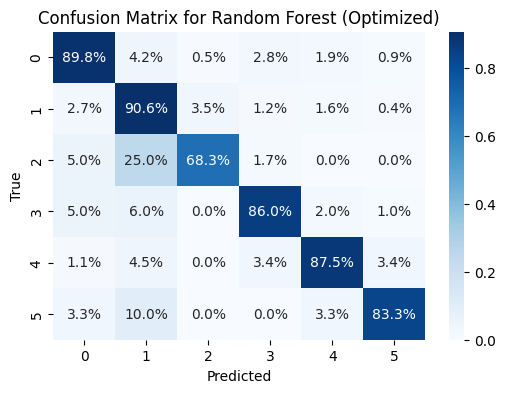

In [16]:
best_dt_model = dt_grid_search.best_estimator_
best_svm_model = svm_grid_search.best_estimator_
best_rf_model = rf_grid_search.best_estimator_

dt_preds = best_dt_model.predict(X_test)
svm_preds = best_svm_model.predict(X_test)
rf_preds = best_rf_model.predict(X_test)

dt_tuned_accuracy, dt_tuned_f1, dt_tuned_cm = evaluate_model(y_test, dt_preds, "Decision Tree (Optimized)")
svm_tuned_accuracy, svm_tuned_f1, svm_tuned_cm = evaluate_model(y_test, svm_preds, "SVM (Optimized)")
rf_tuned_accuracy, rf_tuned_f1, rf_tuned_cm = evaluate_model(y_test, rf_preds, "Random Forest (Optimized)")

## Advanced machine learning

### Larger dataset

In [44]:
ds = load_dataset("dair-ai/emotion", "unsplit")
ds = ds['train'].to_pandas()
ds = ds.sample(50000, replace=True)
ds['text'] = ds['text'].apply(preprocess_text)
# ds['label'] = ds['label'].apply(lambda x: 0 if x == 'sadness' else 1 if x == 'joy' else 2 if x == 'love' else 3 if x == 'anger' else 4 if x == 'fear' else 5)

In [45]:
train_ds, test_ds = train_test_split(ds, test_size=0.2, random_state=17, stratify=ds['label'])

X_train_big = vectorizer.fit_transform(train_ds['text'])
X_test_big = vectorizer.transform(test_ds['text'])

y_train_big = train_ds['label'].values
y_test_big = test_ds['label'].values

Evaluation for Decision Tree (Large Dataset):

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2950
           1       0.93      0.90      0.91      3381
           2       0.79      0.78      0.79       826
           3       0.89      0.90      0.90      1357
           4       0.83      0.85      0.84      1129
           5       0.75      0.77      0.76       357

    accuracy                           0.89     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.89      0.89      0.89     10000

Classification accuracy: 0.887
F1 score: 0.852


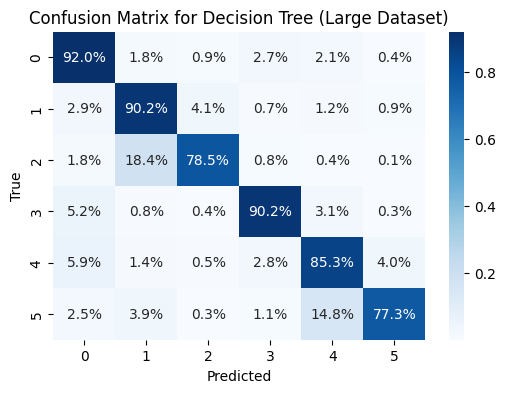

In [46]:
dt_big = DecisionTreeClassifier(random_state=17)
dt_big.fit(X_train_big, y_train_big)

y_pred_big = dt_big.predict(X_test_big)

dt_big_accuracy, dt_big_f1, dt_big_cm = evaluate_model(y_test_big, y_pred_big, "Decision Tree (Large Dataset)")

Evaluation for Naive Bayes (Large Dataset):

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      2950
           1       0.81      0.95      0.87      3381
           2       0.91      0.47      0.62       826
           3       0.92      0.77      0.84      1357
           4       0.86      0.70      0.77      1129
           5       0.89      0.16      0.27       357

    accuracy                           0.83     10000
   macro avg       0.87      0.67      0.71     10000
weighted avg       0.84      0.83      0.82     10000

Classification accuracy: 0.832
F1 score: 0.710


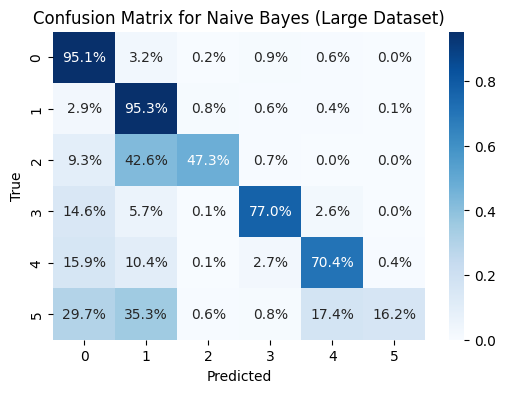

In [47]:
nb_big = MultinomialNB()
nb_big.fit(X_train_big, y_train_big)

y_pred_big = nb_big.predict(X_test_big)

nb_big_accuracy, nb_big_f1, nb_big_cm = evaluate_model(y_test_big, y_pred_big, "Naive Bayes (Large Dataset)")

Evaluation for SVM (Large Dataset):

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2950
           1       0.94      0.89      0.92      3381
           2       0.74      0.90      0.81       826
           3       0.89      0.90      0.89      1357
           4       0.84      0.85      0.85      1129
           5       0.70      0.82      0.76       357

    accuracy                           0.89     10000
   macro avg       0.84      0.88      0.86     10000
weighted avg       0.90      0.89      0.89     10000

Classification accuracy: 0.893
F1 score: 0.859


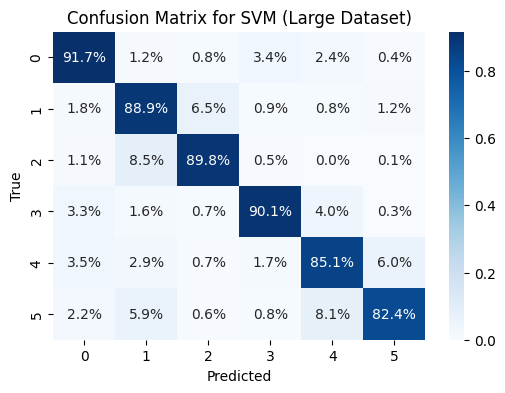

In [48]:
svm_big = SVC(kernel='linear', class_weight='balanced', random_state=17)
svm_big.fit(X_train_big, y_train_big)

y_pred_big = svm_big.predict(X_test_big)

svm_big_accuracy, svm_big_f1, svm_big_cm = evaluate_model(y_test_big, y_pred_big, "SVM (Large Dataset)")

Evaluation for Random Forest (Large Dataset):

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2950
           1       0.93      0.92      0.93      3381
           2       0.82      0.81      0.82       826
           3       0.91      0.89      0.90      1357
           4       0.85      0.86      0.85      1129
           5       0.76      0.81      0.78       357

    accuracy                           0.90     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.90      0.90      0.90     10000

Classification accuracy: 0.903
F1 score: 0.869


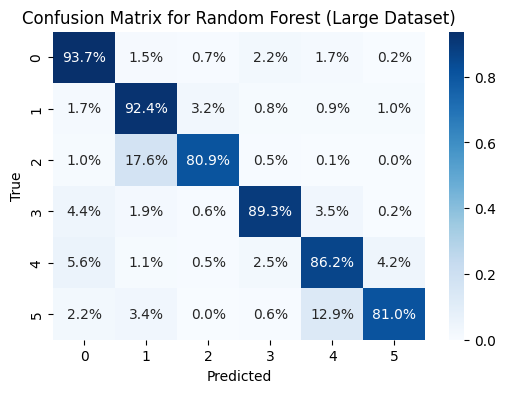

In [49]:
rf_clf_big = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=17, bootstrap=False)
rf_clf_big.fit(X_train_big, y_train_big)

rf_preds_big = rf_clf_big.predict(X_test_big)

rf_accuracy_big, rf_f1_big, rf_cm_big = evaluate_model(y_test_big, rf_preds_big, "Random Forest (Large Dataset)")

### Ensamble models

#### Bagging

Evaluation for Bagging Classifier:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2950
           1       0.95      0.89      0.92      3381
           2       0.77      0.82      0.79       826
           3       0.89      0.92      0.90      1357
           4       0.83      0.88      0.85      1129
           5       0.76      0.78      0.77       357

    accuracy                           0.90     10000
   macro avg       0.85      0.87      0.86     10000
weighted avg       0.90      0.90      0.90     10000

Classification accuracy: 0.896
F1 score: 0.862


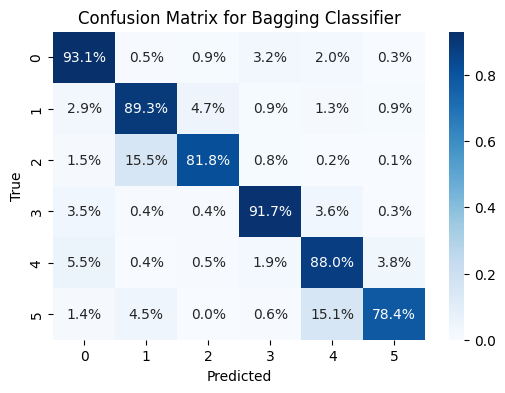

In [ ]:
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=None, random_state=17),
    n_estimators=40,
    random_state=17
)

bagging_clf.fit(X_train_big, y_train_big)

bagging_preds = bagging_clf.predict(X_test_big)

bagging_accuracy, bagging_f1, bagging_cm = evaluate_model(y_test_big, bagging_preds, "Bagging Classifier")

#### Voting

Evaluation for Voting Classifier:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2950
           1       0.92      0.93      0.92      3381
           2       0.84      0.79      0.81       826
           3       0.91      0.88      0.90      1357
           4       0.87      0.83      0.85      1129
           5       0.79      0.74      0.76       357

    accuracy                           0.90     10000
   macro avg       0.87      0.85      0.86     10000
weighted avg       0.90      0.90      0.90     10000

Classification accuracy: 0.899
F1 score: 0.862


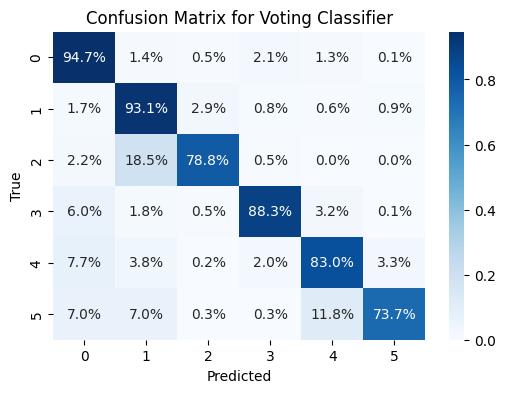

In [56]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=17, bootstrap=False)
svm = SVC(kernel='linear', class_weight='balanced', random_state=17)
naive_bayes = MultinomialNB()

voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('svm', svm), ('naive_bayes', naive_bayes)],
    voting='hard'
)

voting_clf.fit(X_train_big, y_train_big)

voting_preds = voting_clf.predict(X_test_big)

voting_accuracy, voting_f1, voting_cm = evaluate_model(y_test_big, voting_preds, "Voting Classifier")

#### Stacking

c:\Users\JERNEJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluation for Stacking Classifier:

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2950
           1       0.95      0.91      0.93      3381
           2       0.77      0.87      0.82       826
           3       0.91      0.89      0.90      1357
           4       0.85      0.83      0.84      1129
           5       0.72      0.78      0.75       357

    accuracy                           0.90     10000
   macro avg       0.85      0.87      0.86     10000
weighted avg       0.90      0.90      0.90     10000

Classification accuracy: 0.899
F1 score: 0.861


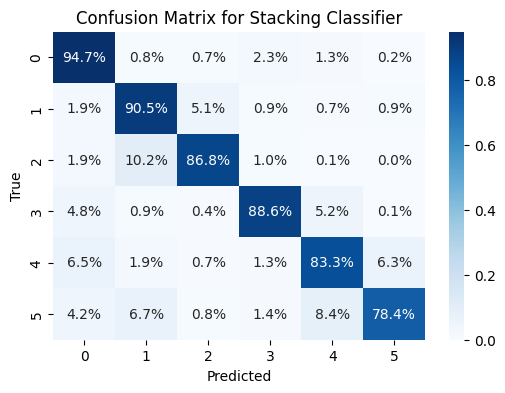

In [57]:
dt = DecisionTreeClassifier(random_state=17)
svm = SVC(kernel='linear', class_weight='balanced', random_state=17)

stacking_clf = StackingClassifier(
    estimators=[('dt', dt), ('svm', svm)],
    final_estimator=MLPClassifier(random_state=17)
)

stacking_clf.fit(X_train_big, y_train_big)

stacking_preds = stacking_clf.predict(X_test_big)

stacking_accuracy, stacking_f1, stacking_cm = evaluate_model(y_test_big, stacking_preds, "Stacking Classifier")

#### Boosting

Evaluation for XGBoost:

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2950
           1       0.93      0.92      0.92      3381
           2       0.78      0.87      0.82       826
           3       0.92      0.89      0.90      1357
           4       0.87      0.86      0.86      1129
           5       0.74      0.83      0.78       357

    accuracy                           0.91     10000
   macro avg       0.86      0.89      0.87     10000
weighted avg       0.91      0.91      0.91     10000

Classification accuracy: 0.905
F1 score: 0.873


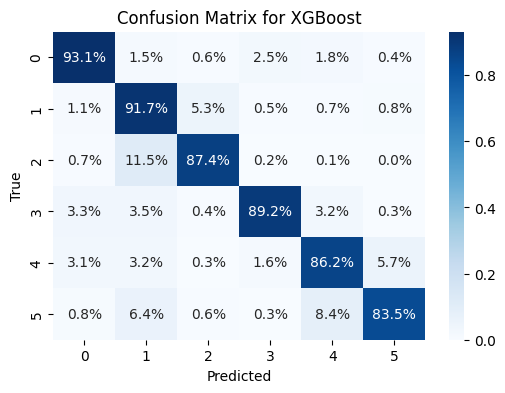

In [59]:
xgb_clf = XGBClassifier(n_estimators=2000, max_depth=1, random_state=17)
xgb_clf.fit(X_train_big, y_train_big)

xgb_preds = xgb_clf.predict(X_test_big)

xgb_accuracy, xgb_f1, xgb_cm = evaluate_model(y_test_big, xgb_preds, "XGBoost")

### Fine-tuning a pre-trained model

In [32]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.005,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 750/750 [00:00<00:00, 6817.15 examples/s]
c:\Users\JERNEJ\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\JERNEJ\AppData\Local\Temp\ipykernel_15424\536614794.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# trainer.train()

In [ ]:
# model.save_pretrained("./emotion-classifier_")
# tokenizer.save_pretrained("./emotion-classifier_")

# print("Model and tokenizer saved to './emotion-classifier_'")

Map: 100%|██████████| 750/750 [00:00<00:00, 7385.74 examples/s]
C:\Users\JERNEJ\AppData\Local\Temp\ipykernel_15424\3162195170.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
100%|██████████| 94/94 [01:52<00:00,  1.20s/it]


              precision    recall  f1-score   support

     sadness       0.94      0.94      0.94       216
         joy       0.94      0.92      0.93       256
        love       0.80      0.82      0.81        60
       anger       0.91      0.94      0.93       100
        fear       0.89      0.91      0.90        88
    surprise       0.86      0.80      0.83        30

    accuracy                           0.92       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.92      0.92      0.92       750

Classification accuracy: 0.916
F1 score: 0.889


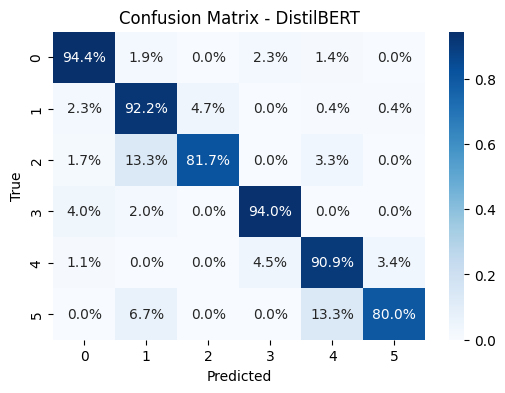

In [ ]:
test_dataset = Dataset.from_pandas(test_df)
test_dataset = test_dataset.map(tokenize, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

model = AutoModelForSequenceClassification.from_pretrained("./emotion-classifier")
tokenizer = AutoTokenizer.from_pretrained("./emotion-classifier")

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
)

predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)

print(
    classification_report(
        test_df["label"],
        predicted_labels,
        target_names=["sadness", "joy", "love", "anger", "fear", "surprise"],
    )
)

pretrained_accuracy = accuracy_score(test_df["label"], predicted_labels)
pretrained_f1 = f1_score(test_df["label"], predicted_labels, average='macro')
print(f"Classification accuracy: {pretrained_accuracy:.3f}")
print(f"F1 score: {pretrained_f1:.3f}")

pretrained_cm = confusion_matrix(test_df["label"], predicted_labels)
pretrained_cm = pretrained_cm.astype('float') / pretrained_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 4))
sns.heatmap(pretrained_cm, annot=True, fmt='.1%', cmap='Blues', xticklabels=np.unique(test_df['label']), yticklabels=np.unique(test_df['label']))
plt.title("Confusion Matrix - DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Results